### (week4) Home Credit Default Risk

![img](https://storage.googleapis.com/kaggle-competitions/kaggle/9120/logos/header.png)

>`Cf.`
> + [Home-Credit-Default-Risk - github](https://github.com/rishabhrao1997/Home-Credit-Default-Risk/blob/main/EDA%20-%20Home%20Credit%20Default.ipynb)
> + [HOME CREDIT DEFAULT RISK — An End to End ML Case Study — PART 1: Introduction and EDA - medium](https://medium.com/thecyphy/home-credit-default-risk-part-1-3bfe3c7ddd7a)
> + [HOME CREDIT DEFAULT RISK — An End to End ML Case Study — PART 1: Introduction and EDA](https://medium.com/thecyphy/home-credit-default-risk-part-1-3bfe3c7ddd7a)
> + [HOME CREDIT DEFAULT RISK — An End to End ML Case Study — PART 2: Feature Engineering and Modelling](https://medium.com/thecyphy/home-credit-default-risk-part-2-84b58c1ab9d5)
> + [機械学習によく使うPythonのコード一覧まとめ - AI研究所](https://ai-kenkyujo.com/2020/06/08/kikaigakusyu-python/#i)

> ```point.```
> Supervised Classfication

##### - import

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings(action="ignore")

# algorithm
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier #XGBoost
from lightgbm import LGBMClassifier #LightGBM

# evaluations
from sklearn.metrics import accuracy_score # 正解率
from sklearn.metrics import precision_score # 適合率
from sklearn.metrics import recall_score # 再現率
from sklearn.metrics import f1_score # F値
from sklearn.metrics import confusion_matrix # 混合行列

# visualization
import missingno as msn
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import IPython
def display(*dfs, head=True):
    for df in dfs:
        IPython.display.display(df.head() if head else df)

#### 【問題1】コンペティション内容の確認
> + (a) 何を学習し、何を予測するのか
> + (b) どのようなファイルを作りKaggleに提出するか
> + (c) 提出されたものはどういった指標値で評価されるのか

(a): Targetになりうるクライアントの返済能力を予測

(b): [提出ファイル - kaggle](https://www.kaggle.com/c/home-credit-default-risk/overview/evaluation)で指定されているファイルを作成して提出

(c): 予測された確率と観察されたターゲットの間の[ROC曲線](https://ja.wikipedia.org/wiki/%E5%8F%97%E4%BF%A1%E8%80%85%E6%93%8D%E4%BD%9C%E7%89%B9%E6%80%A7)の下の領域

#### 【問題2】学習と検証
> データを簡単に分析、前処理し、学習、検証するまでの一連の流れを作成・実行してください。

> `memo`
> Kagglerは最低限のデータセットでSubmitしてみて、Scoreがどの程度かを検証したりするそう。

##### - Dataset

In [2]:
train_raw = pd.read_csv('input/application_train.csv')
test_raw = pd.read_csv('input/application_test.csv')
print('The size of the train data :', train_raw.shape)
print('The size of the test data :', test_raw.shape)

#train testのフラグつける
train_mid = train_raw.copy()
train_mid['train_or_test'] = 'train'
test_mid = test_raw.copy()
test_mid['train_or_test'] = 'test'
test_mid['TARGET'] = 0.5

alldata = pd.concat([train_mid, test_mid], sort=False, axis=0).reset_index(drop=True)
print('The size of the alldata data:', alldata.shape)

The size of the train data : (307511, 122)
The size of the test data : (48744, 121)
The size of the alldata data: (356255, 123)


In [3]:
train_mid.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,train_or_test
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,train
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,train
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,train
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,train
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,train


In [4]:
test_mid.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,train_or_test,TARGET
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0.0,0.0,0.0,0.0,0.0,0.0,test,0.5
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0.0,0.0,0.0,0.0,0.0,3.0,test,0.5
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0.0,0.0,0.0,0.0,1.0,4.0,test,0.5
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0.0,0.0,0.0,0.0,0.0,3.0,test,0.5
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,0,0,NaN,NaN,NaN,NaN,NaN,NaN,test,0.5


In [5]:
alldata

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,train_or_test
0,100002,1.0,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,train
1,100003,0.0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,train
2,100004,0.0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,train
3,100006,0.0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,train
4,100007,0.0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
356250,456221,0.5,Cash loans,F,N,Y,0,121500.0,412560.0,17473.5,...,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,test
356251,456222,0.5,Cash loans,F,N,N,2,157500.0,622413.0,31909.5,...,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,test
356252,456223,0.5,Cash loans,F,Y,Y,1,202500.0,315000.0,33205.5,...,0,0,0,0.0,0.0,0.0,0.0,3.0,1.0,test
356253,456224,0.5,Cash loans,M,N,N,0,225000.0,450000.0,25128.0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0,test


##### （問題３まで、NaN全部消しバージョン）

##### - EDA / Preprocessing

<AxesSubplot:>

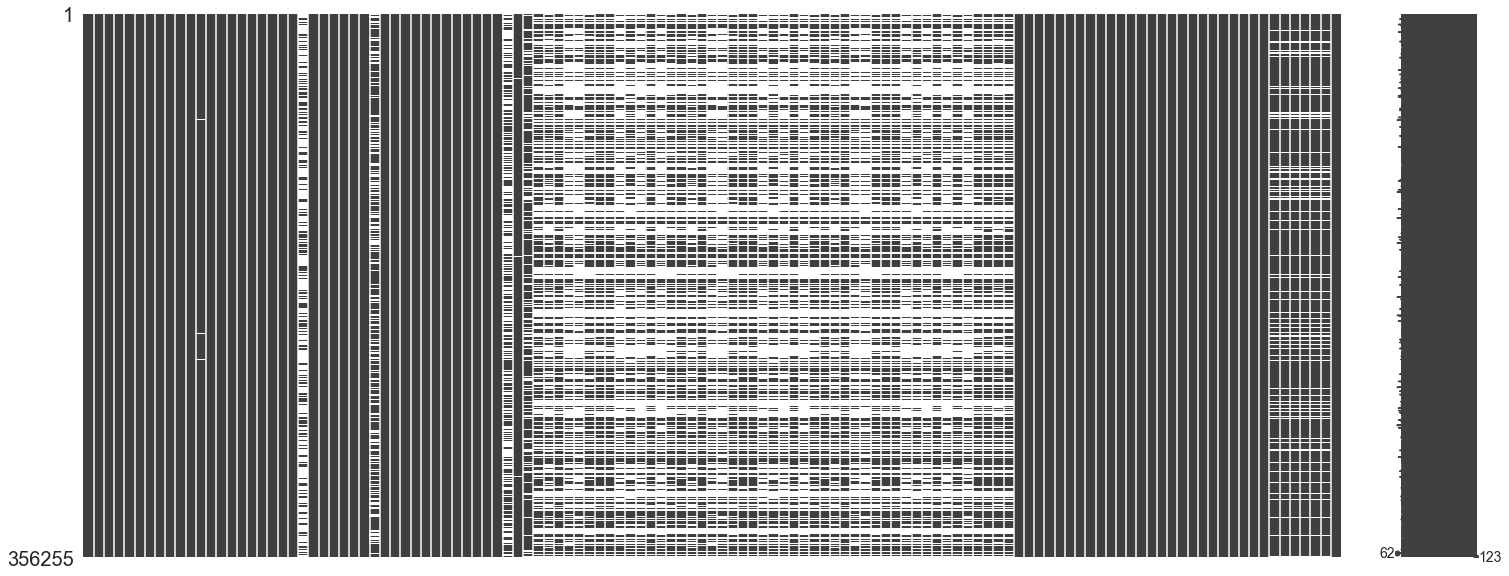

In [6]:
# 欠損データの分布確認
msn.matrix(alldata)

In [7]:
# 欠損データall除去
alldata = alldata.dropna(how="any")

(10341, 123)
SK_ID_CURR                    0
TARGET                        0
NAME_CONTRACT_TYPE            0
CODE_GENDER                   0
FLAG_OWN_CAR                  0
                             ..
AMT_REQ_CREDIT_BUREAU_WEEK    0
AMT_REQ_CREDIT_BUREAU_MON     0
AMT_REQ_CREDIT_BUREAU_QRT     0
AMT_REQ_CREDIT_BUREAU_YEAR    0
train_or_test                 0
Length: 123, dtype: int64


<AxesSubplot:>

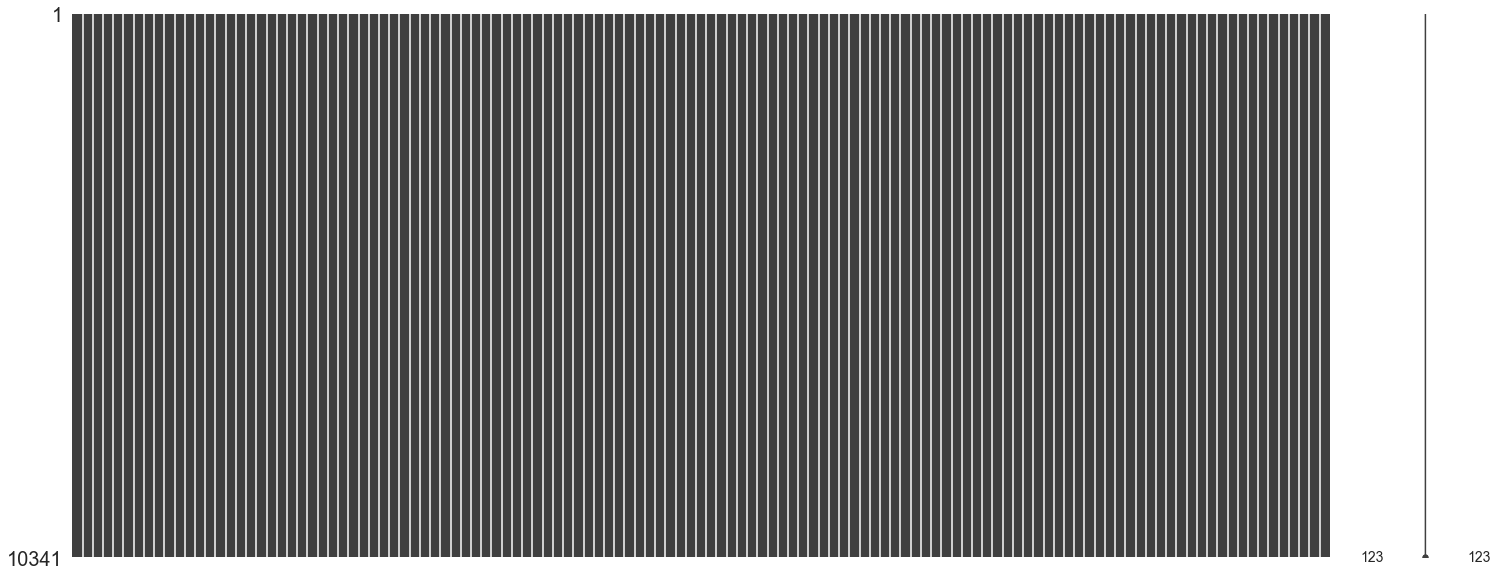

In [8]:
print(alldata.shape)
print(alldata.isnull().sum())
msn.matrix(alldata)

In [9]:
# オブジェクト型を全て Label-Encoding
alldata.columns[alldata.dtypes == object]

Index(['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
       'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE',
       'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE', 'FONDKAPREMONT_MODE',
       'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE',
       'train_or_test'],
      dtype='object')

In [10]:
alldata = pd.get_dummies(alldata)

In [11]:
# オブジェクト型が無くなったので確認
alldata.columns[alldata.dtypes == object]

Index([], dtype='object')

In [12]:
alldata.head(3)

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,train_or_test_test,train_or_test_train
71,100083,0.0,0,103500.0,573628.5,24435.0,463500.0,0.009657,-15406,-892,...,0,0,0,0,1,0,1,0,0,1
124,100145,0.0,1,202500.0,260725.5,16789.5,198000.0,0.018850,-16282,-4375,...,0,0,0,1,0,0,1,0,0,1
152,100179,0.0,0,202500.0,675000.0,53329.5,675000.0,0.031329,-11375,-2311,...,0,1,0,0,0,0,1,0,0,1


In [13]:
# 最初に統合したtrainとtestを分離
train_feature = alldata[alldata['train_or_test_train']==1]
test_feature = alldata[alldata['train_or_test_train']==0]
train_target = train_feature["TARGET"]
print("train: {}".format(train_feature.shape))
print("test: {}".format(test_feature.shape))

train: (8602, 238)
test: (1739, 238)


In [14]:
# 分割
X_train, X_test, y_train, y_test = train_test_split(train_feature, train_target, test_size=0.2, random_state=0)

print("X_train: {}\nX_test: {}\ny_train: {}\ny_test: {}".format(X_train.shape, X_test.shape, y_train.shape, y_test.shape))

X_train: (6881, 238)
X_test: (1721, 238)
y_train: (6881,)
y_test: (1721,)


##### - Baseline

In [15]:
ratio = y_train.sum() / len(y_train)
print(f'Target rate:{ratio}')
print(f'base line accuracy: {1 - ratio}')

Target rate:0.05943903502397907
base line accuracy: 0.9405609649760209


##### -Normalize

In [16]:
#標準化
sts = StandardScaler()
sts.fit(X_train, y_train)
X_train_norm = sts.transform(X_train)

##### -Machine Learning
    ロジスティック回帰、ランダムフォレストで学習

In [19]:
# ロジスティック回帰
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
logreg_ev = evaluations(y_test, y_pred, "macro")

In [20]:
# ランダムフォレスト
rfc = RandomForestClassifier(random_state=0)
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)
rfc_ev = evaluations(y_test, y_pred, "macro")

##### - Evaliation

In [18]:
def evaluations(test, predict, average):
    accuracy = accuracy_score(test, predict)
    precision = precision_score(test, predict, average=average)
    recall = recall_score(test, predict, average=average)
    f1 = f1_score(test, predict, average=average)
    evaluations = {
        "正解率" : round(accuracy, 3), 
        "適合率" : round(precision, 3),
        "再現率" : round(recall, 3), 
        "F値" : round(f1, 3)
    }
    return evaluations

In [21]:
pd.DataFrame([logreg_ev, rfc_ev], index=["ロジスティック回帰", "ランダムフォレスト"])

,正解率,適合率,再現率,F値
ロジスティック回帰,0.932,0.466,0.500,0.482
ランダムフォレスト,0.997,0.998,0.979,0.988


試しにRondomforestの`feature_importances_`を見てみる

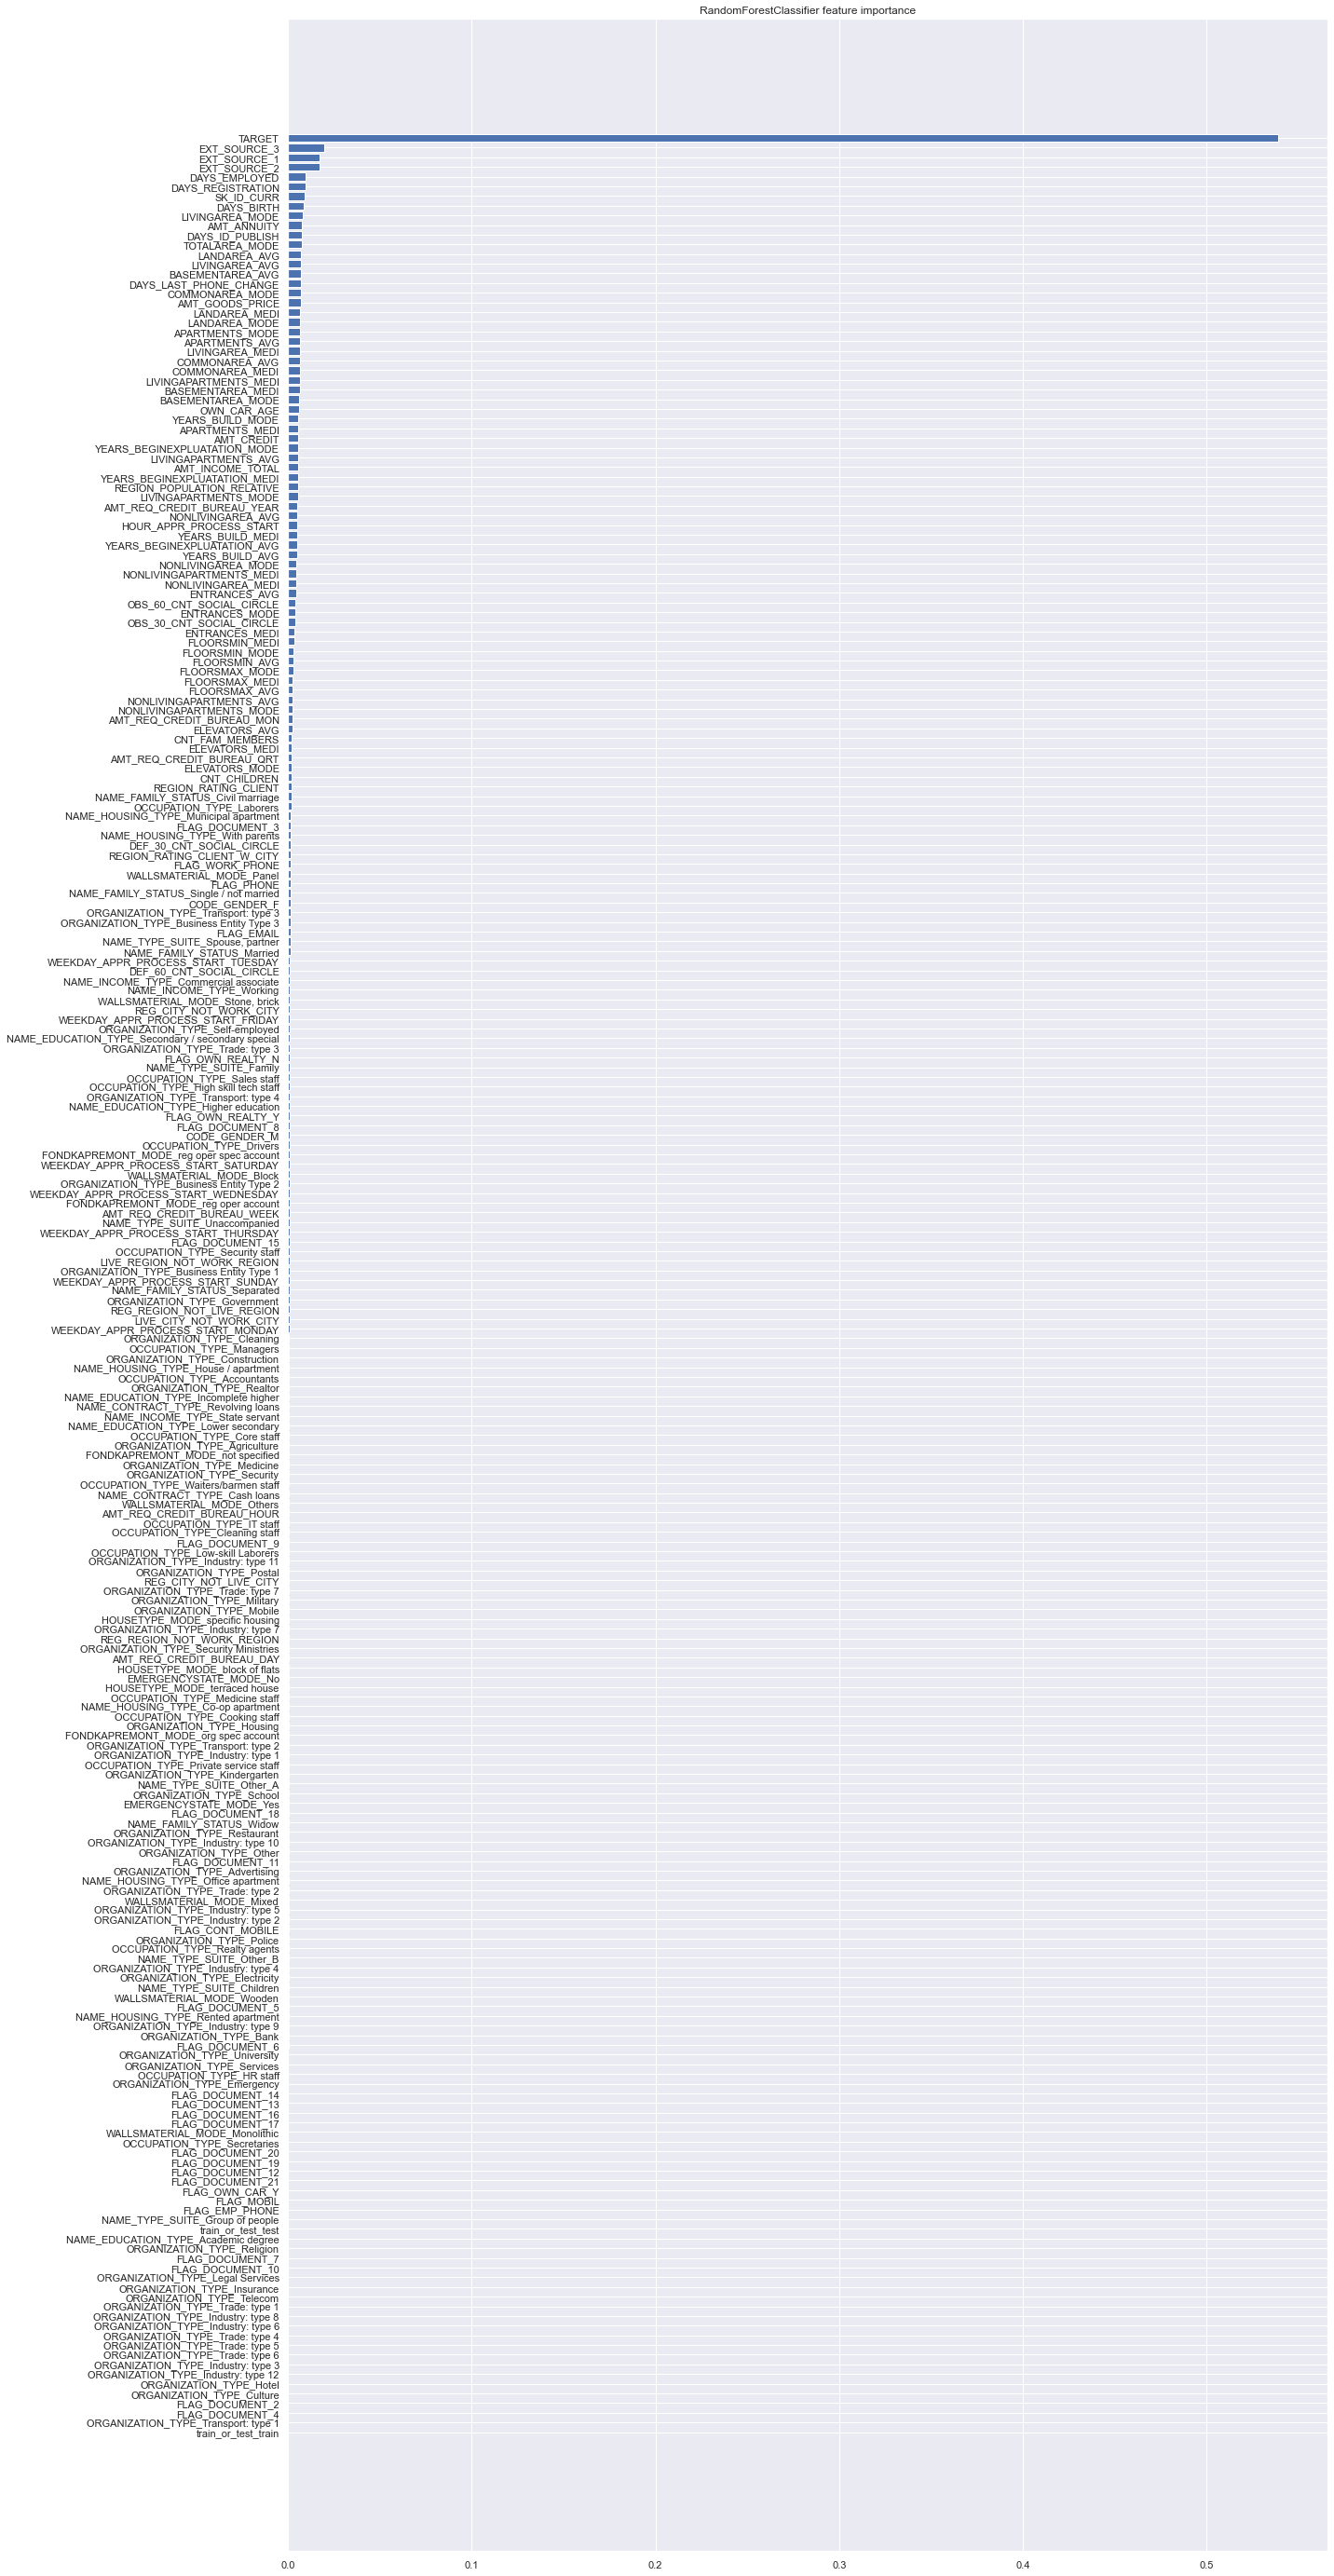

In [22]:
rfc.fit(X_train, y_train)
# n = rfc.feature_importances_
n = np.argsort(rfc.feature_importances_) # 数列の順位的なの返す
x = X_train.columns[n]
y = rfc.feature_importances_[n]

plt.figure(figsize=(20, 50))
plt.barh(x, y, label="Rondom Forest Classfire")
plt.title('RandomForestClassifier feature importance')
plt.show()

#### 【問題3】テストデータに対する推定
> テストデータ（`application_test.csv`）に対して推定を行い、Kaggleに提出を行ってください。

In [23]:
test_feature

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,train_or_test_test,train_or_test_train
307526,100107,0.5,0,180000.0,296280.0,21690.0,225000.0,0.032561,-13563,-1007,...,0,0,0,0,1,0,1,0,1,0
307529,100128,0.5,1,225000.0,431280.0,23526.0,360000.0,0.025164,-10962,-1883,...,0,0,0,1,0,0,1,0,1,0
307584,100561,0.5,0,180000.0,67500.0,8140.5,67500.0,0.015221,-11819,-2612,...,0,0,0,1,0,0,1,0,1,0
307597,100699,0.5,1,225000.0,323460.0,23134.5,270000.0,0.020246,-13444,-1659,...,0,0,0,1,0,0,1,0,1,0
307613,100770,0.5,0,202500.0,697500.0,33687.0,697500.0,0.015221,-8819,-852,...,0,0,0,1,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
356139,455243,0.5,1,112500.0,252531.0,26005.5,234000.0,0.016612,-10205,-2038,...,0,0,0,0,1,0,1,0,1,0
356181,455607,0.5,0,387000.0,350415.0,25051.5,292500.0,0.025164,-20876,-4409,...,0,0,0,0,1,0,1,0,1,0
356193,455703,0.5,1,450000.0,790830.0,57676.5,675000.0,0.035792,-9952,-1437,...,0,0,0,0,1,0,1,0,1,0
356218,455940,0.5,0,202500.0,225000.0,19242.0,225000.0,0.010006,-10159,-632,...,0,0,0,0,1,0,1,0,1,0


In [24]:
X_test = test_feature.values # (1739, 238)

> `Cf.`
> + [scikit-learn – predict_proba - TauStation](http://taustation.com/scikit-learn-predict_proba/)
>> 1列目に「０」になる確率、２列目に「１」になる確率

In [25]:
# ロジスティック回帰
logreg = LogisticRegression(random_state=0)
logreg.fit(X_train, y_train) #(6881, 238) (6881, )
logreg_pred = logreg.predict_proba(X_test)

In [26]:
# ランダムフォレスト
rfc = RandomForestClassifier(random_state=0)
rfc.fit(X_train, y_train)
rfc_pred = rfc.predict_proba(X_test)

#### - submit

In [27]:
a = pd.DataFrame([np.round(logreg_pred[:, 1])]).T

In [28]:
a.head()

,0
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0


In [29]:
b = pd.DataFrame([test_feature["SK_ID_CURR"].values]).T

In [30]:
submit = pd.concat([b, a], axis=1)
submit = submit.rename(columns={0 : "SK_ID_CURR", 1 : "TARGET" })
submit.to_csv('output/demo_logreg.csv', index=False)

#### 【問題4】特徴量エンジニアリング
>     精度を上げるために以下のような観点で 特徴量エンジニアリング（Feature Engineering） を行ってください。
>        - どの特徴量を使うか
>        - どう前処理をするか
>     何をした時に検証データに対する評価指標がどのようになったかをまとめてください。最低5パターンの学習・検証を行ってください。

In [ ]:
# pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)

##### - dataset2

In [31]:
display(train_mid.head(5))
display(test_mid.head(3))

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,train_or_test
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,train
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,train
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,train
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,train
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,train


,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,train_or_test,TARGET
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0.0,0.0,0.0,0.0,0.0,0.0,test,0.5
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0.0,0.0,0.0,0.0,0.0,3.0,test,0.5
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0.0,0.0,0.0,0.0,1.0,4.0,test,0.5


In [32]:
df = pd.concat([train_mid, test_mid]).reset_index(drop=True)
display(df.head(3))
display(df.tail(3))
df.shape

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,train_or_test
0,100002,1.0,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,train
1,100003,0.0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,train
2,100004,0.0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,train


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,train_or_test
356252,456223,0.5,Cash loans,F,Y,Y,1,202500.0,315000.0,33205.5,...,0,0,0,0.0,0.0,0.0,0.0,3.0,1.0,test
356253,456224,0.5,Cash loans,M,N,N,0,225000.0,450000.0,25128.0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0,test
356254,456250,0.5,Cash loans,F,Y,N,0,135000.0,312768.0,24709.5,...,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0,test


(356255, 123)

##### - EDA2 / Preprocessing2

In [33]:
# NaN's countup
def nan_rank(df,  usabilty=20):
    """
    df :
    データフレーム
    usabilty :
    データの割合に応じての足切りライン
    """
    nan = df.isnull().sum().reset_index()
    nan.columns = ["name", "count"]
    nan["ratio"] = (nan["count"] / df.shape[0])*100
    nan["usabilty"] = np.where(nan["ratio"] > usabilty, "Discard", "Keep")
    nan = nan[nan["count"] > 0].sort_values(by="ratio")
    
    plt.figure(figsize=(15, 6))
    sns.barplot(x=nan["name"], y=nan["ratio"])
    plt.xticks(rotation=90) #90°傾け
    plt.title("Feature containing NaN.")
    plt.show()
    return nan

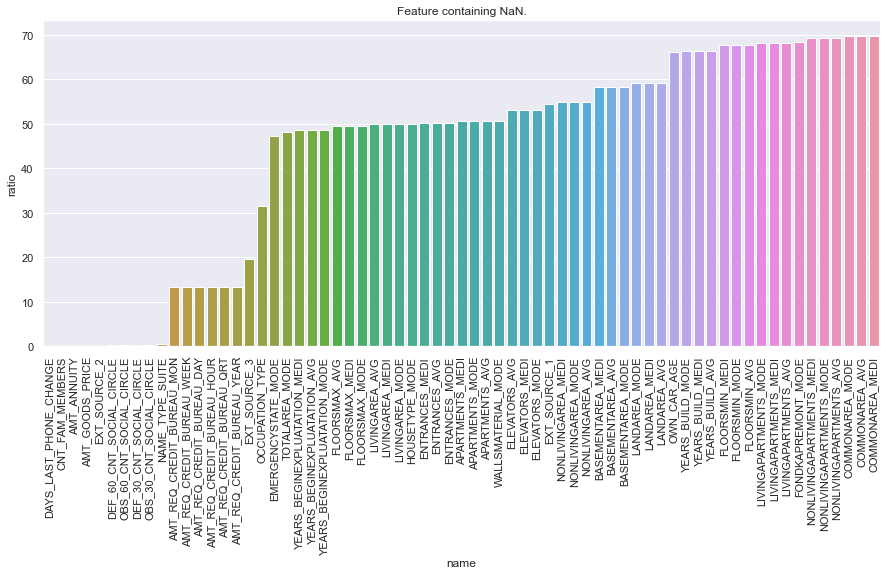

In [34]:
nan = nan_rank(df)

In [35]:
# nan Discardのカラム名をdfから除去
drop_list = nan[nan["usabilty"] == "Discard"]["name"].values.tolist()
df = df.drop(drop_list, axis=1)

In [36]:
print("# columns: ", len(df.columns))

# columns:  73


In [ ]:
# こいつらをどうしようか…
keep_nan = nan[nan["usabilty"]=="Keep"]
keep_nan

In [37]:
# objリストのカラムを数値化
obj_list = df.columns[df.dtypes == "object"].tolist()
print(obj_list, len(obj_list), type(obj_list))

# 変換したdf作成
obj_df = pd.get_dummies(df[obj_list])
display(obj_df.head(3))

#dfとobj_dfを合体
df = df.drop(obj_list, axis=1) # obj_listのカラム名の列を削除
df = pd.concat([df, obj_df], axis=1)
df.head(3)

['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE', 'train_or_test'] 12 <class 'list'>


,NAME_CONTRACT_TYPE_Cash loans,NAME_CONTRACT_TYPE_Revolving loans,CODE_GENDER_F,CODE_GENDER_M,CODE_GENDER_XNA,FLAG_OWN_CAR_N,FLAG_OWN_CAR_Y,FLAG_OWN_REALTY_N,FLAG_OWN_REALTY_Y,NAME_TYPE_SUITE_Children,...,ORGANIZATION_TYPE_Trade: type 6,ORGANIZATION_TYPE_Trade: type 7,ORGANIZATION_TYPE_Transport: type 1,ORGANIZATION_TYPE_Transport: type 2,ORGANIZATION_TYPE_Transport: type 3,ORGANIZATION_TYPE_Transport: type 4,ORGANIZATION_TYPE_University,ORGANIZATION_TYPE_XNA,train_or_test_test,train_or_test_train
0,1,0,0,1,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
1,1,0,1,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,1,0,1,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,1


,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,ORGANIZATION_TYPE_Trade: type 6,ORGANIZATION_TYPE_Trade: type 7,ORGANIZATION_TYPE_Transport: type 1,ORGANIZATION_TYPE_Transport: type 2,ORGANIZATION_TYPE_Transport: type 3,ORGANIZATION_TYPE_Transport: type 4,ORGANIZATION_TYPE_University,ORGANIZATION_TYPE_XNA,train_or_test_test,train_or_test_train
0,100002,1.0,0,202500.0,406597.5,24700.5,351000.0,0.018801,-9461,-637,...,0,0,0,0,0,0,0,0,0,1
1,100003,0.0,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,-16765,-1188,...,0,0,0,0,0,0,0,0,0,1
2,100004,0.0,0,67500.0,135000.0,6750.0,135000.0,0.010032,-19046,-225,...,0,0,0,0,0,0,0,0,0,1


In [38]:
df.columns[df.dtypes=="object"]

Index([], dtype='object')

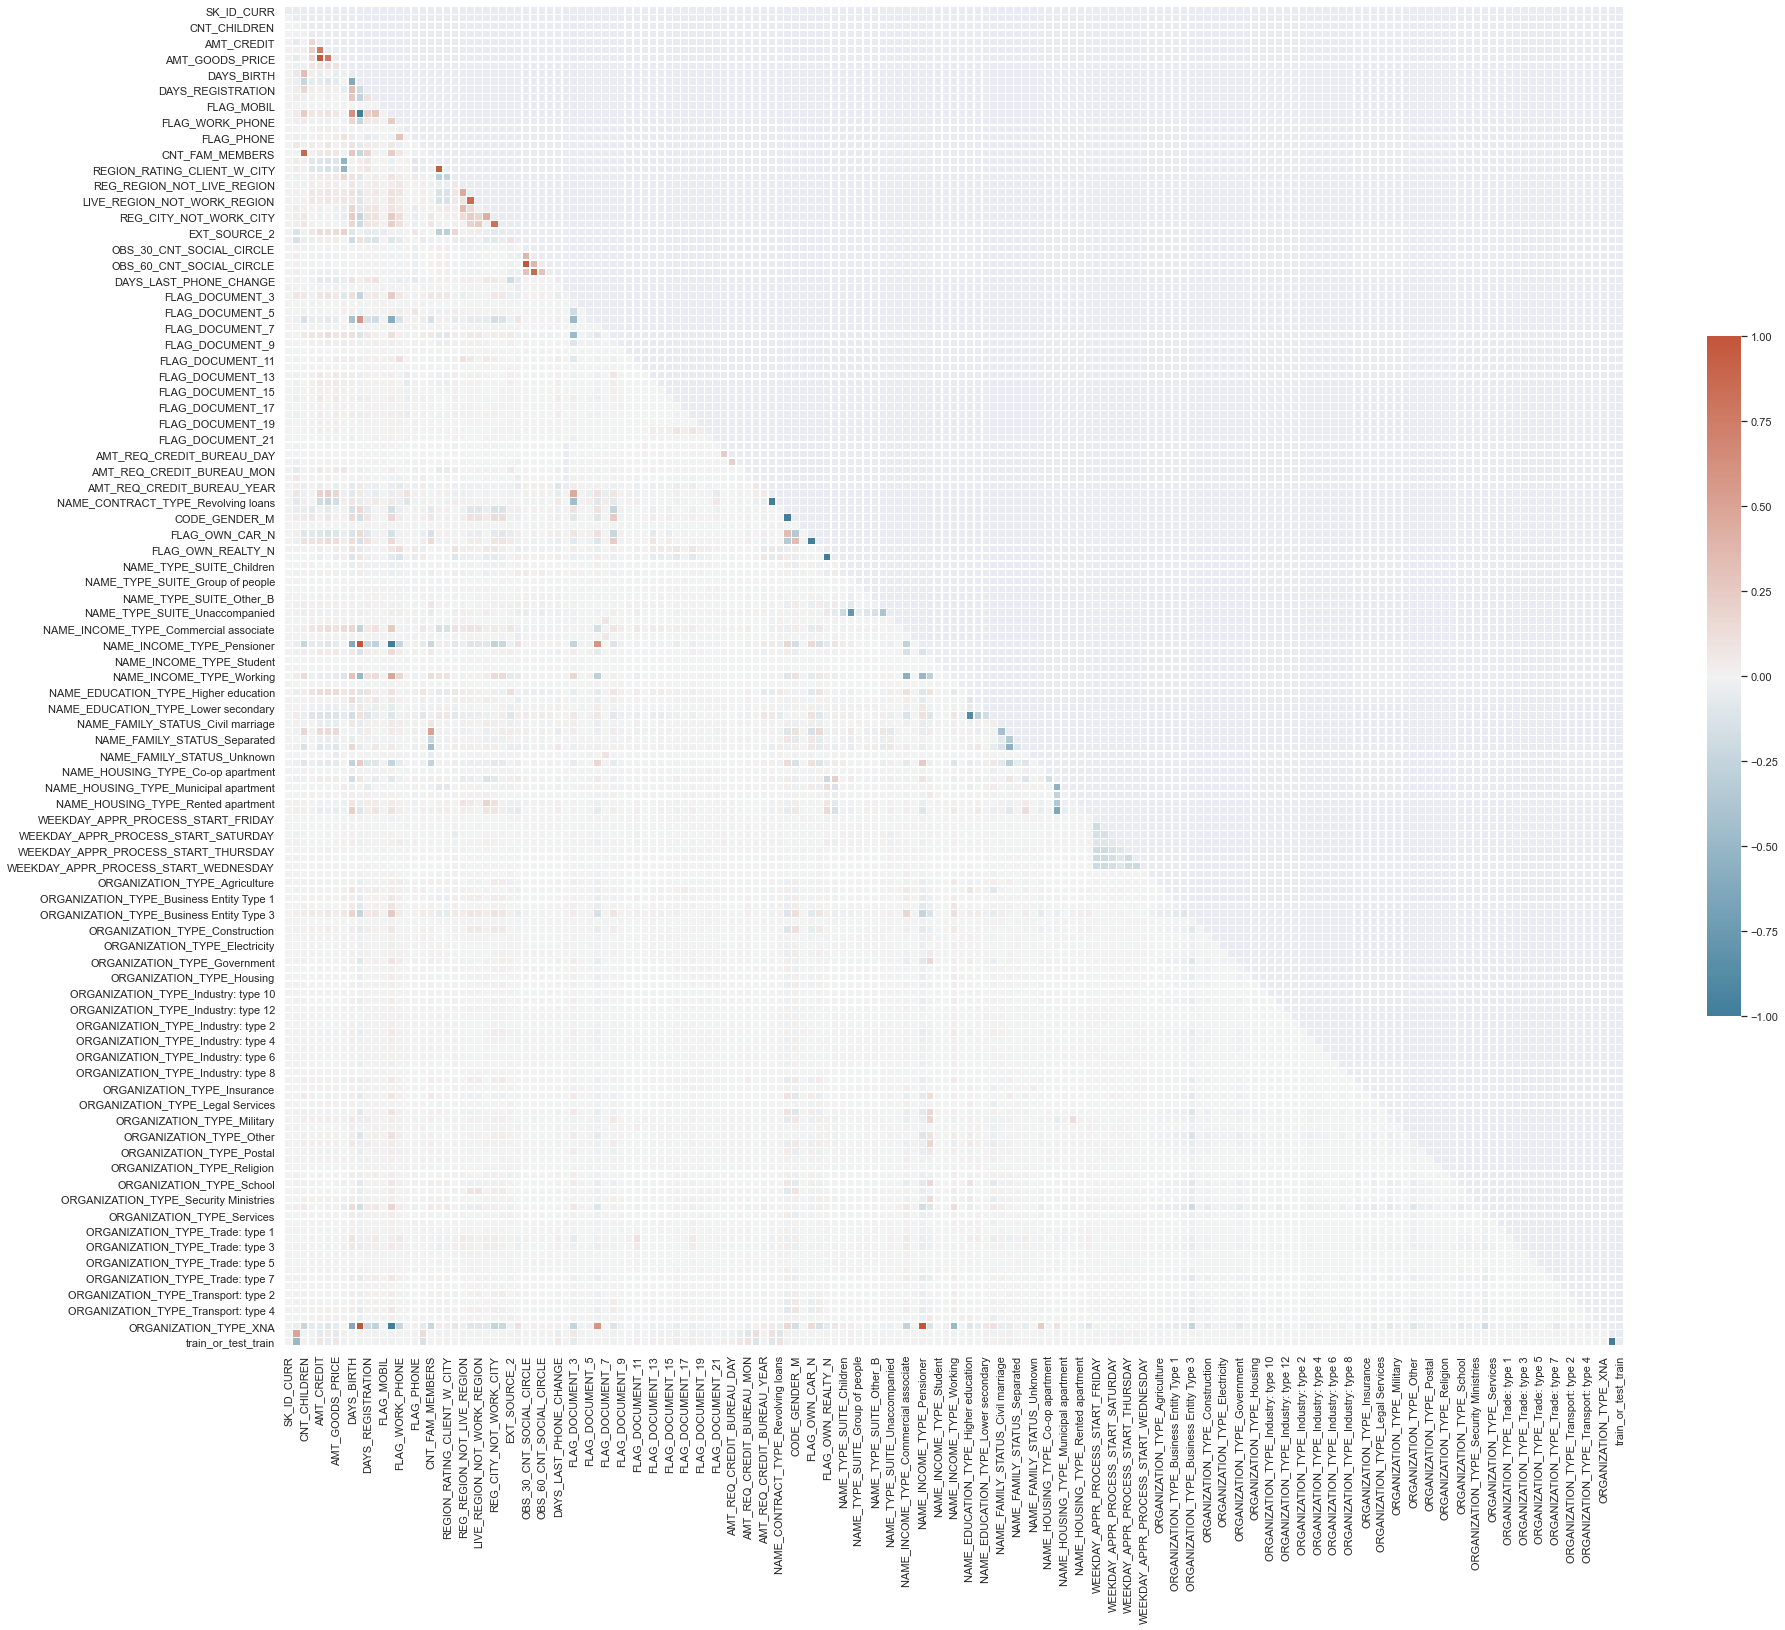

In [39]:
# Correlation Matrix
f, ax = plt.subplots(figsize=(30, 25))
mat = df.corr("pearson")
mask = np.triu(np.ones_like(mat, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(mat, mask=mask, cmap=cmap, vmax=1, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

In [40]:
# 相関関係の降順を見てみる
mat["TARGET"].sort_values(ascending=False) # 降順指定

TARGET                                1.000000
train_or_test_test                    0.494742
NAME_CONTRACT_TYPE_Cash loans         0.079486
FLAG_EMAIL                            0.068751
FLAG_DOCUMENT_3                       0.065225
                                        ...   
AMT_GOODS_PRICE                      -0.067517
NAME_CONTRACT_TYPE_Revolving loans   -0.079486
EXT_SOURCE_2                         -0.127158
EXT_SOURCE_3                         -0.153189
train_or_test_train                  -0.494742
Name: TARGET, Length: 169, dtype: float64

In [41]:
# 相関関係の低いカラムをリストアップ
drop_list = mat.columns[mat["TARGET"] < 0].tolist()
# 予め、必要になるカラムは除いておく
drop_list.remove("SK_ID_CURR")
drop_list.remove("train_or_test_train")

In [78]:
df = df.drop(drop_list, axis=1)

> `Cf.`
> + [2019 Data Science Bowl](https://www.kaggle.com/c/data-science-bowl-2019/discussion/122021)
> + [初めてのLightGBM](https://fukki.pythonanywhere.com/post_detail/19/)

In [79]:
# 最初に統合したtrainとtestを分離
train = df[df['train_or_test_train'] == 1]
test = df[df['train_or_test_test'] == 1]

In [80]:
print(f"train: {train.shape} , test: {test.shape}")

train: (307511, 78) , test: (48744, 78)


In [81]:
add_drop = ["SK_ID_CURR", "TARGET", "train_or_test_train", "train_or_test_test"]

In [82]:
# 学習に必要な特徴量のみを保持
train_tagert = train[ "TARGET"]
train_feature = train.drop(add_drop, axis=1)
test_feature = test.drop(add_drop, axis=1)

In [83]:
print(f"train_feature: {train_feature.shape}, train_target: {train_target.shape}, test_feature: {test_feature.shape}")

train_feature: (307511, 74), train_target: (8602,), test_feature: (48744, 74)


In [84]:
# NaNが未だいるから削除
print(train_feature.columns[train_feature.isnull().sum()>0])
print(test_feature.columns[test_feature.isnull().sum()>0])

Index(['AMT_ANNUITY', 'CNT_FAM_MEMBERS', 'OBS_30_CNT_SOCIAL_CIRCLE',
       'DEF_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE',
       'DEF_60_CNT_SOCIAL_CIRCLE', 'DAYS_LAST_PHONE_CHANGE',
       'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR'],
      dtype='object')
Index(['AMT_ANNUITY', 'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE',
       'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE',
       'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR'],
      dtype='object')


In [85]:
redrop_list = train_feature.columns[train_feature.isnull().sum() > 0].tolist()

In [86]:
train_feature = train_feature.drop(redrop_list, axis=1)
test_feature = test_feature.drop(redrop_list, axis=1)

In [87]:
print(f"train_feature: {train_feature.shape}, train_target: {train_target.shape}, test_feature: {test_feature.shape}")

train_feature: (307511, 65), train_target: (8602,), test_feature: (48744, 65)


In [88]:
# LightGBMではJSON形式はcolumn名に使われているとparseができずにエラーが起こる
train_feature.columns = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in train_feature.columns]
test_feature.columns = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in test_feature.columns]

In [89]:
# trainデータを分割
X_train, X_test, y_train, y_test = train_test_split(
    train_feature, train_tagert, test_size=0.2, random_state=0, stratify=train_tagert)

##### - Baseline
> (精度の基準となるモデル)

In [90]:
# trainから頻度に応じて単純なモデルを作る場合
ratio = y_train.sum()/len(y_train)

print(f'rate:{ratio}')
print(f'base line accuracy: {1 - ratio}')

survive rate:0.05943903502397907
base line accuracy: 0.9405609649760209


##### - Normalize

In [91]:
#標準化
sts = StandardScaler()
sts.fit(X_train, y_train)
X_train_norm = sts.transform(X_train)

##### - Machine Leaning
> `Cf.`
> + [.scoreで出てくる決定係数の解釈 - teratail](https://teratail.com/questions/100203)
> + [機械学習ライブラリ scikit-learnの便利機能の紹介 - Qiita](https://qiita.com/ishizakiiii/items/0650723cc2b4eef2c1cf)

In [92]:
# LogisticRegression
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
print("="*20)
print("LogisticRegression")
print("train acc: ", logreg.score(X_train, y_train))
print("test acc: ", logreg.score(X_test, y_test))

LogisticRegression
train acc:  0.9192709180189262
test acc:  0.9192722306228964


In [93]:
# RandomForest
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
print("="*20)
print("RandomForest")
print("train acc: ", rfc.score(X_train, y_train))
print("test acc: ", rfc.score(X_test, y_test))

RandomForest
train acc:  0.9999512210985009
test acc:  0.9999837406305383


In [94]:
# XGBoost
xgb = XGBClassifier()
xgb.fit(X_train, y_train)
print("="*20)
print("XGBBoost")
print("train acc: ", xgb.score(X_train, y_train))
print("test acc: ", xgb.score(X_test, y_test))

[20:22:24] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBBoost
train acc:  0.9197546421254593
test acc:  0.9197762710762076


In [95]:
# LightGBM
lgb = LGBMClassifier()
lgb.fit(X_train, y_train)
print("="*20)
print("LightGBM")
print("train acc: ", lgb.score(X_train, y_train))
print("test acc: ", lgb.score(X_test, y_test))

LightGBM
train acc:  0.9192790478358427
test acc:  0.9193047493618197


In [98]:
# SVC
svc = SVC()
svc.fit(X_train, y_train)
print("="*20)
print("SVC")
print("train acc: ", svc.score(X_train, y_train))
print("test acc: ", svc.score(X_test, y_test))

KeyboardInterrupt: 

Text(0.5, 1.0, 'RandomForestClassifier feature importance')

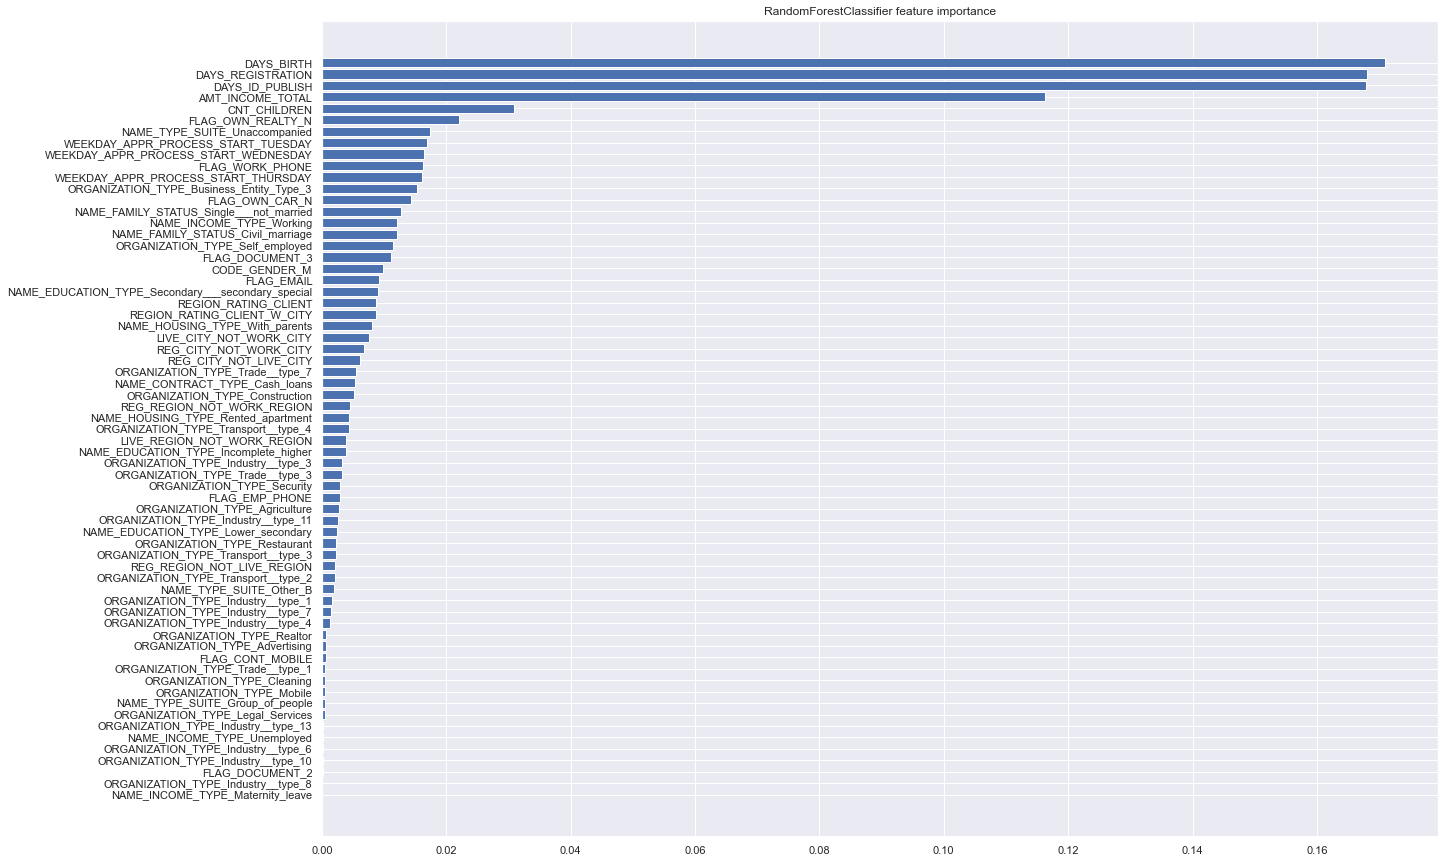

In [97]:
plt.figure(figsize=(20,15))
plt.barh(
    X_train.columns[np.argsort(rfc.feature_importances_)],
    rfc.feature_importances_[np.argsort(rfc.feature_importances_)],
    label='RandomForestClassifier'
)
plt.title('RandomForestClassifier feature importance')

##### - Parameter tuning
> `Cf.`
> + [ハイパーパラメーター最適化フレームワークOptunaの実装解説 - CyberAgent AI tech stdio](https://cyberagent.ai/optuna-from-scratch)

In [103]:
from sklearn.model_selection import StratifiedKFold, cross_validate
import optuna

cv = 5 #CV分割数(クロスバリデーション)

In [104]:
def objective(trial):
    
    param_grid_rfc = {
        "max_depth": trial.suggest_int("max_depth", 5, 15),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 5),
        'min_samples_split': trial.suggest_int("min_samples_split", 7, 15),
        "criterion": trial.suggest_categorical("criterion", ["gini", "entropy"]),
        'max_features': trial.suggest_int("max_features", 3, 10),
        "random_state": 0
    }

    model = RandomForestClassifier(**param_grid_rfc)
    
    # 5-Fold CV / Accuracy でモデルを評価する
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
    scores = cross_validate(model, X=X_train, y=y_train, cv=kf)
    # 最小化なので 1.0 からスコアを引く
    return scores['test_score'].mean()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)
print(study.best_params)
print(study.best_value)
rfc_best_param = study.best_params

[I 2021-02-02 13:53:54,711] A new study created in memory with name: no-name-7b95a6d3-fcf1-46cf-af0c-d22e75453ae0
[I 2021-02-02 13:54:53,759] Trial 0 finished with value: 0.9192709180109226 and parameters: {'max_depth': 9, 'min_samples_leaf': 5, 'min_samples_split': 15, 'criterion': 'gini', 'max_features': 6}. Best is trial 0 with value: 0.9192709180109226.
[I 2021-02-02 13:55:45,262] Trial 1 finished with value: 0.9192709180109226 and parameters: {'max_depth': 5, 'min_samples_leaf': 3, 'min_samples_split': 9, 'criterion': 'entropy', 'max_features': 10}. Best is trial 0 with value: 0.9192709180109226.
[I 2021-02-02 13:57:17,479] Trial 2 finished with value: 0.9192709180109226 and parameters: {'max_depth': 14, 'min_samples_leaf': 1, 'min_samples_split': 10, 'criterion': 'entropy', 'max_features': 6}. Best is trial 0 with value: 0.9192709180109226.
[I 2021-02-02 13:58:34,787] Trial 3 finished with value: 0.9192709180109226 and parameters: {'max_depth': 8, 'min_samples_leaf': 2, 'min_samp

{'max_depth': 9, 'min_samples_leaf': 5, 'min_samples_split': 15, 'criterion': 'gini', 'max_features': 6}
0.9192709180109226


In [105]:
def objective(trial):
    
    param_grid_xgb = {
        'min_child_weight': trial.suggest_int("min_child_weight", 1, 5),
        'gamma': trial.suggest_discrete_uniform("gamma", 0.1, 1.0, 0.1),
        'subsample': trial.suggest_discrete_uniform("subsample", 0.5, 1.0, 0.1),
        'colsample_bytree': trial.suggest_discrete_uniform("colsample_bytree", 0.5, 1.0, 0.1),
        'max_depth': trial.suggest_int("max_depth", 3, 10),
        "random_state": 0
    }

    model = XGBClassifier(**param_grid_xgb)
    
    # 5-Fold CV / Accuracy でモデルを評価する
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
    scores = cross_validate(model, X=X_train, y=y_train, cv=kf)
    # 最小化なので 1.0 からスコアを引く
    return scores['test_score'].mean()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)
print(study.best_params)
print(study.best_value)
xgb_best_param = study.best_params

[I 2021-02-02 14:18:41,139] A new study created in memory with name: no-name-bb16e10a-1553-489f-b168-448de3b7b97e


[14:18:41] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:18:55] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:19:09] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:19:23] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective

[I 2021-02-02 14:19:55,554] Trial 0 finished with value: 0.9192302689263359 and parameters: {'min_child_weight': 1, 'gamma': 0.4, 'subsample': 0.8, 'colsample_bytree': 1.0, 'max_depth': 4}. Best is trial 0 with value: 0.9192302689263359.


[14:19:56] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:20:07] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:20:19] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:20:32] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective

[I 2021-02-02 14:20:57,297] Trial 1 finished with value: 0.9192587233020703 and parameters: {'min_child_weight': 1, 'gamma': 0.7000000000000001, 'subsample': 0.7, 'colsample_bytree': 1.0, 'max_depth': 3}. Best is trial 1 with value: 0.9192587233020703.


[14:20:58] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:21:19] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:21:40] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:22:01] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective

[I 2021-02-02 14:22:43,910] Trial 2 finished with value: 0.9187302847067373 and parameters: {'min_child_weight': 3, 'gamma': 0.7000000000000001, 'subsample': 0.8, 'colsample_bytree': 0.7, 'max_depth': 8}. Best is trial 1 with value: 0.9192587233020703.


[14:22:44] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:23:19] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:23:55] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:24:27] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective

[I 2021-02-02 14:25:29,103] Trial 3 finished with value: 0.9162141081553672 and parameters: {'min_child_weight': 2, 'gamma': 0.30000000000000004, 'subsample': 0.5, 'colsample_bytree': 0.9, 'max_depth': 10}. Best is trial 1 with value: 0.9192587233020703.


[14:25:29] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:25:58] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:26:27] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:26:56] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective

[I 2021-02-02 14:27:52,302] Trial 4 finished with value: 0.9167547413769348 and parameters: {'min_child_weight': 3, 'gamma': 0.1, 'subsample': 0.5, 'colsample_bytree': 0.8, 'max_depth': 10}. Best is trial 1 with value: 0.9192587233020703.


[14:27:53] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:28:19] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:28:46] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:29:12] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective

[I 2021-02-02 14:30:13,109] Trial 5 finished with value: 0.9185351696129513 and parameters: {'min_child_weight': 1, 'gamma': 1.0, 'subsample': 1.0, 'colsample_bytree': 0.7, 'max_depth': 10}. Best is trial 1 with value: 0.9192587233020703.


[14:30:13] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:30:27] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:30:39] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:30:51] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective

[I 2021-02-02 14:31:15,880] Trial 6 finished with value: 0.919266853135511 and parameters: {'min_child_weight': 3, 'gamma': 0.4, 'subsample': 0.9, 'colsample_bytree': 1.0, 'max_depth': 3}. Best is trial 6 with value: 0.919266853135511.


[14:31:16] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:31:44] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:32:12] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:32:38] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective

[I 2021-02-02 14:33:35,805] Trial 7 finished with value: 0.9173319559986742 and parameters: {'min_child_weight': 5, 'gamma': 0.9, 'subsample': 0.5, 'colsample_bytree': 0.7, 'max_depth': 10}. Best is trial 6 with value: 0.919266853135511.


[14:33:36] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:34:00] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:34:24] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:34:46] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective

[I 2021-02-02 14:35:29,022] Trial 8 finished with value: 0.91894978987917 and parameters: {'min_child_weight': 3, 'gamma': 0.5, 'subsample': 0.9, 'colsample_bytree': 0.7, 'max_depth': 8}. Best is trial 6 with value: 0.919266853135511.


[14:35:29] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:36:01] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:36:33] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:37:08] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective

[I 2021-02-02 14:38:15,675] Trial 9 finished with value: 0.9177953579093057 and parameters: {'min_child_weight': 1, 'gamma': 0.1, 'subsample': 0.7, 'colsample_bytree': 1.0, 'max_depth': 9}. Best is trial 6 with value: 0.919266853135511.


{'min_child_weight': 3, 'gamma': 0.4, 'subsample': 0.9, 'colsample_bytree': 1.0, 'max_depth': 3}
0.919266853135511


##### - 汎化性能確認

In [106]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

rfc_best = RandomForestClassifier(**rfc_best_param)
print('■ RandomForestClassifier')
scores = cross_validate(rfc_best, X=train_feature, y=train_tagert, cv=kf)
print(f'mean:{scores["test_score"].mean()}, std:{scores["test_score"].std()}')
print('='*20)

xgb_best = XGBClassifier(**xgb_best_param)
print('■ XGBClassifier')
scores = cross_validate(xgb_best, X=train_feature, y=train_tagert, cv=kf)
print(f'mean:{scores["test_score"].mean()}, std:{scores["test_score"].std()}')
print('='*20)

■ RandomForestClassifier
mean:0.9192711805397202, std:5.250415880730941e-07
■ XGBClassifier
[14:46:20] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:46:34] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:46:50] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:47:09] WARNING: /Users/travis/build/dmlc/xgboost/src/learn

##### - （試しに） 多数決

In [107]:
from sklearn.ensemble import VotingClassifier

# voting に使う分類器を用意する
estimators = [
    ('rfc', RandomForestClassifier(**rfc_best_param)),
    ('xgb', XGBClassifier(**xgb_best_param))]

voting = VotingClassifier(estimators)

print('■ VotingClassifier')
scores = cross_validate(voting, X=train_feature, y=train_tagert, cv=kf)
print(f'mean:{scores["test_score"].mean()}, std:{scores["test_score"].std()}')

■ VotingClassifier
[14:48:17] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:48:46] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:49:16] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:49:50] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used

##### - Submition

In [111]:
# RandomForest
rfc = RandomForestClassifier(**rfc_best_param)
rfc.fit(train_feature, train_tagert)

xgb = XGBClassifier(**xgb_best_param)
xgb.fit(train_feature, train_tagert)

# 推論
pred = {
    'rfc': rfc.predict(test_feature),
    'xgb': xgb.predict(test_feature)
}

# ファイル出力
for key, value in pred.items():
    pd.concat(
        [
            pd.DataFrame(test.SK_ID_CURR, columns=["SK_ID_CURR"]).reset_index(drop=True),
            pd.DataFrame(value, columns=["TARGET"])
        ],
        axis=1
    ).to_csv(f'output/{key}.csv', index=False)

[15:04:58] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
